# <center> UFOs and the Weather: A Technical Report

## <center> Sebastion Matthews, Ethan France

### <center> CPSC 322, Fall 2024

In [19]:
import openpyxl
import math
import random
from collections import Counter, defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

# Import classifiers
from MyNaiveBayesClassifier import MyNaiveBayesClassifier
from MyRandomForestClassifier import MyRandomForestClassifier

def read_excel(file_path):
    workbook = openpyxl.load_workbook(file_path)
    sheet = workbook.active
    data = []
    for row in sheet.iter_rows(values_only=True):
        data.append(list(row))
    return data[1:]  # Skip the header

def normalize_units(row, indices):
    normalized_row = []
    for i in indices:
        value = row[i]
        if i in range(13, 16):
            normalized_row.append(value / 100 if value is not None else None)
        else:
            normalized_row.append(value)
    return normalized_row

def load_filtered_dataset(file_path):
    data = read_excel(file_path)
    filtered_data = []
    relevant_indices = list(range(10, 26)) + [-1]

    for row in data:
        if any(row[i] is None for i in relevant_indices):
            continue

        label = row[-1]
        if isinstance(label, str):
            label = label.strip().lower()
            label = 1 if label == "yes" else 0 if label == "no" else None

        if label is None or not all(isinstance(row[i], (int, float)) for i in relevant_indices[:-1]):
            continue

        normalized_row = normalize_units(row, relevant_indices[:-1])
        filtered_data.append(normalized_row + [label])

    if not filtered_data:
        raise ValueError("No valid rows found in the dataset. Please check the data and column indices.")

    features = [row[:-1] for row in filtered_data]
    labels = [row[-1] for row in filtered_data]
    return features, labels

def split_data(X, y, test_ratio=0.2):
    combined = list(zip(X, y))
    random.shuffle(combined)
    split_idx = int(len(combined) * (1 - test_ratio))
    train_set, test_set = combined[:split_idx], combined[split_idx:]
    return (
        [x for x, _ in train_set], [y for _, y in train_set],
        [x for x, _ in test_set], [y for _, y in test_set]
    )

def calculate_feature_importance_naive_bayes(nb_classifier):
    importance = {}
    for label, feature_probs in nb_classifier.feature_probabilities.items():
        for feature_index, (mean, variance) in feature_probs.items():
            importance[feature_index] = importance.get(feature_index, 0) + abs(mean)
    return importance

def calculate_feature_importance_random_forest(rf_classifier):
    feature_importance = Counter()
    for tree in rf_classifier.forest:
        def traverse(node, depth=0):
            if isinstance(node, dict):  # Internal node
                feature_importance[node['feature']] += 1
                traverse(node['left'], depth + 1)
                traverse(node['right'], depth + 1)
        traverse(tree.tree)
    return dict(feature_importance)

def visualize_combined_scores_and_features(metrics, nb_importance, rf_importance, feature_names):
    classifiers = list(metrics.keys())
    accuracy = [metrics[clf]["Accuracy"] for clf in classifiers]
    precision = [metrics[clf]["Precision"] for clf in classifiers]
    recall = [metrics[clf]["Recall"] for clf in classifiers]
    f1_scores = [metrics[clf]["F1"] for clf in classifiers]

    x = np.arange(len(classifiers))
    width = 0.2

    plt.figure(figsize=(14, 8))

    # Bar plot for scores
    plt.bar(x - width, accuracy, width, label="Accuracy", color="skyblue")
    plt.bar(x, precision, width, label="Precision", color="orange")
    plt.bar(x + width, recall, width, label="Recall", color="green")

    plt.xticks(x, classifiers)
    plt.ylabel("Score")
    plt.title("Classifier Metrics Comparison")
    plt.legend()
    plt.show()

    # F1 Score Comparison
    plt.figure(figsize=(8, 6))
    plt.bar(classifiers, f1_scores, color="purple")
    plt.ylabel("F1 Score")
    plt.title("F1 Score Comparison")
    plt.show()

    # Feature importance comparison
    sorted_nb_importance = sorted(nb_importance.items(), key=lambda x: x[1], reverse=True)
    sorted_rf_importance = sorted(rf_importance.items(), key=lambda x: x[1], reverse=True)

    nb_features = [feature_names[i] for i, _ in sorted_nb_importance]
    nb_values = [val for _, val in sorted_nb_importance]

    rf_features = [feature_names[i] for i, _ in sorted_rf_importance]
    rf_values = [val for _, val in sorted_rf_importance]

    plt.figure(figsize=(12, 6))
    plt.barh(nb_features, nb_values, color="blue", alpha=0.6, label="Naive Bayes")
    plt.barh(rf_features, rf_values, color="red", alpha=0.6, label="Random Forest")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance Comparison")
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()

if __name__ == "__main__":
    try:
        file_path = 'merged_weather_ufo.xlsx'
        features, labels = load_filtered_dataset(file_path)
        X_train, y_train, X_test, y_test = split_data(features, labels)

        # Feature names
        feature_names = [
            "Temperature (°F) Max", "Temperature (°F) Avg", "Temperature (°F) Min", 
            "Dew Point (°F) Max", "Dew Point (°F) Avg", "Dew Point (°F) Min", 
            "Humidity (%) Max", "Humidity (%) Avg", "Humidity (%) Min", 
            "Wind Speed (mph) Max", "Wind Speed (mph) Avg", "Wind Speed (mph) Min", 
            "Pressure (in) Max", "Pressure (in) Avg", "Pressure (in) Min", 
            "Precipitation (in) Total"
        ]

        metrics = {}

        # Train and analyze Naive Bayes
        nb_classifier = MyNaiveBayesClassifier()
        nb_classifier.fit(X_train, y_train)
        nb_predictions = nb_classifier.predict(X_test)
        nb_importance = calculate_feature_importance_naive_bayes(nb_classifier)
        tp = sum(1 for true, pred in zip(y_test, nb_predictions) if true == pred == 1)
        tn = sum(1 for true, pred in zip(y_test, nb_predictions) if true == pred == 0)
        fp = sum(1 for true, pred in zip(y_test, nb_predictions) if true == 0 and pred == 1)
        fn = sum(1 for true, pred in zip(y_test, nb_predictions) if true == 1 and pred == 0)
        metrics["Naive Bayes"] = {
            "Accuracy": (tp + tn) / len(y_test),
            "Precision": tp / (tp + fp) if (tp + fp) > 0 else 0,
            "Recall": tp / (tp + fn) if (tp + fn) > 0 else 0,
            "F1": 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
        }

        # Train and analyze Random Forest
        rf_classifier = MyRandomForestClassifier(n_trees=26, m_trees=5, f_features=2)
        rf_classifier.fit(X_train, y_train)
        rf_predictions = rf_classifier.predict(X_test)
        rf_importance = calculate_feature_importance_random_forest(rf_classifier)
        tp = sum(1 for true, pred in zip(y_test, rf_predictions) if true == pred == 1)
        tn = sum(1 for true, pred in zip(y_test, rf_predictions) if true == pred == 0)
        fp = sum(1 for true, pred in zip(y_test, rf_predictions) if true == 0 and pred == 1)
        fn = sum(1 for true, pred in zip(y_test, rf_predictions) if true == 1 and pred == 0)
        metrics["Random Forest"] = {
            "Accuracy": (tp + tn) / len(y_test),
            "Precision": tp / (tp + fp) if (tp + fp) > 0 else 0,
            "Recall": tp / (tp + fn) if (tp + fn) > 0 else 0,
            "F1": 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
        }

        print(("Naive Bayes: ")+(metrics["Naive Bayes"]))
        print(("Random Forest: ")+(metrics["Random Forest"]))

        visualize_combined_scores_and_features(metrics, nb_importance, rf_importance, feature_names)

    except Exception as e:
        print(f"Error: {e}")


Error: can only concatenate str (not "dict") to str


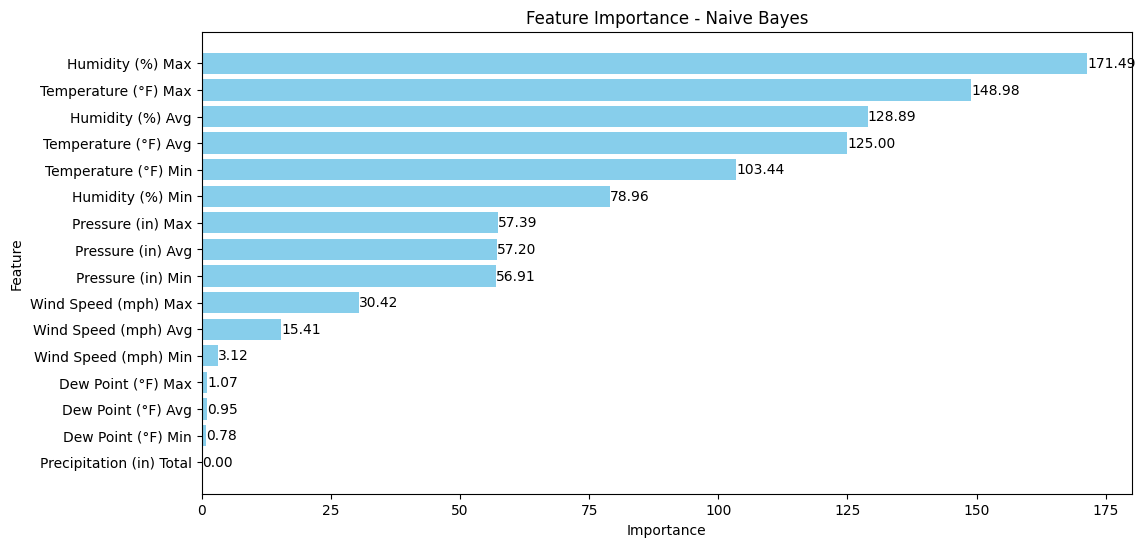

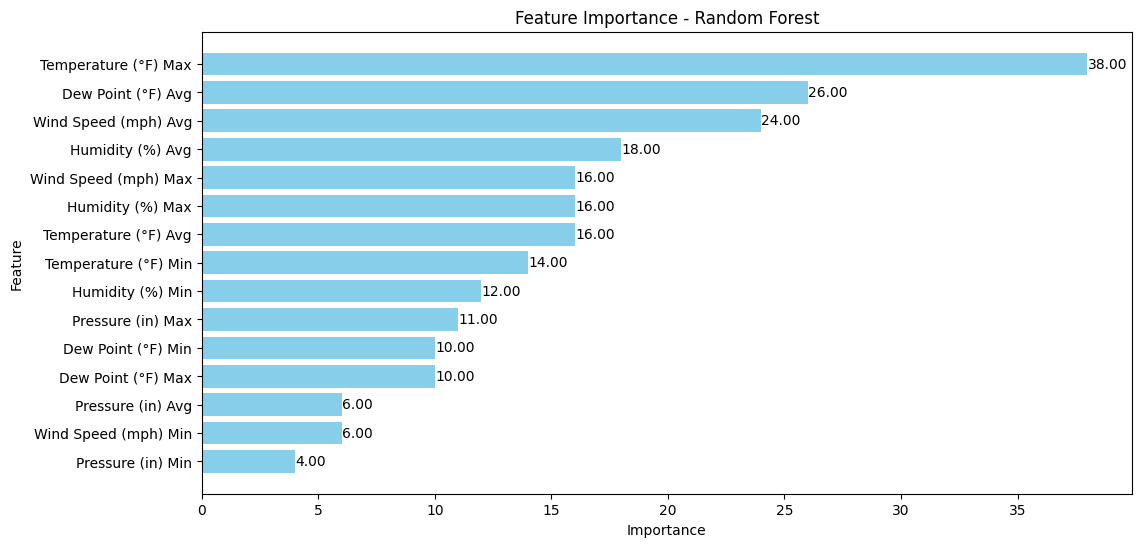

In [7]:
import openpyxl
import math
import random
from collections import Counter, defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

# Import classifiers
from MyNaiveBayesClassifier import MyNaiveBayesClassifier
from MyRandomForestClassifier import MyRandomForestClassifier

def read_excel(file_path):
    workbook = openpyxl.load_workbook(file_path)
    sheet = workbook.active
    data = []
    for row in sheet.iter_rows(values_only=True):
        data.append(list(row))
    return data[1:]  # Skip the header

def normalize_units(row, indices):
    normalized_row = []
    for i in indices:
        value = row[i]
        if i in range(13, 16):
            normalized_row.append(value / 100 if value is not None else None)
        else:
            normalized_row.append(value)
    return normalized_row

def load_filtered_dataset(file_path):
    data = read_excel(file_path)
    filtered_data = []
    relevant_indices = list(range(10, 26)) + [-1]

    for row in data:
        if any(row[i] is None for i in relevant_indices):
            continue

        label = row[-1]
        if isinstance(label, str):
            label = label.strip().lower()
            label = 1 if label == "yes" else 0 if label == "no" else None

        if label is None or not all(isinstance(row[i], (int, float)) for i in relevant_indices[:-1]):
            continue

        normalized_row = normalize_units(row, relevant_indices[:-1])
        filtered_data.append(normalized_row + [label])

    if not filtered_data:
        raise ValueError("No valid rows found in the dataset. Please check the data and column indices.")

    features = [row[:-1] for row in filtered_data]
    labels = [row[-1] for row in filtered_data]
    return features, labels

def split_data(X, y, test_ratio=0.2):
    combined = list(zip(X, y))
    random.shuffle(combined)
    split_idx = int(len(combined) * (1 - test_ratio))
    train_set, test_set = combined[:split_idx], combined[split_idx:]
    return (
        [x for x, _ in train_set], [y for _, y in train_set],
        [x for x, _ in test_set], [y for _, y in test_set]
    )

def calculate_feature_importance_naive_bayes(nb_classifier):
    importance = {}
    for label, feature_probs in nb_classifier.feature_probabilities.items():
        for feature_index, (mean, variance) in feature_probs.items():
            importance[feature_index] = importance.get(feature_index, 0) + abs(mean)
    return importance

def calculate_feature_importance_random_forest(rf_classifier):
    feature_importance = Counter()
    for tree in rf_classifier.forest:
        def traverse(node, depth=0):
            if isinstance(node, dict):  # Internal node
                feature_importance[node['feature']] += 1
                traverse(node['left'], depth + 1)
                traverse(node['right'], depth + 1)
        traverse(tree.tree)
    return dict(feature_importance)

def visualize_feature_importance(importance, feature_names, title):
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    features = [feature_names[i] for i, _ in sorted_importance]
    values = [val for _, val in sorted_importance]

    plt.figure(figsize=(12, 6))
    bars = plt.barh(features, values, color="skyblue")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title(title)
    plt.gca().invert_yaxis()

    # Add data labels
    for bar in bars:
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center')

    plt.show()

if __name__ == "__main__":
    try:
        file_path = 'merged_weather_ufo.xlsx'
        features, labels = load_filtered_dataset(file_path)
        X_train, y_train, X_test, y_test = split_data(features, labels)

        # Feature names
        feature_names = [
            "Temperature (°F) Max", "Temperature (°F) Avg", "Temperature (°F) Min", 
            "Dew Point (°F) Max", "Dew Point (°F) Avg", "Dew Point (°F) Min", 
            "Humidity (%) Max", "Humidity (%) Avg", "Humidity (%) Min", 
            "Wind Speed (mph) Max", "Wind Speed (mph) Avg", "Wind Speed (mph) Min", 
            "Pressure (in) Max", "Pressure (in) Avg", "Pressure (in) Min", 
            "Precipitation (in) Total"
        ]

        # Train and analyze Naive Bayes
        nb_classifier = MyNaiveBayesClassifier()
        nb_classifier.fit(X_train, y_train)
        nb_importance = calculate_feature_importance_naive_bayes(nb_classifier)
        visualize_feature_importance(nb_importance, feature_names, "Feature Importance - Naive Bayes")

        # Train and analyze Random Forest
        rf_classifier = MyRandomForestClassifier(n_trees=10, m_trees=3, f_features=2)
        rf_classifier.fit(X_train, y_train)
        rf_importance = calculate_feature_importance_random_forest(rf_classifier)
        visualize_feature_importance(rf_importance, feature_names, "Feature Importance - Random Forest")

    except Exception as e:
        print(f"Error: {e}")


# Naive Bayes Feature Importance:

## Importance is based on the absolute mean values of the Gaussian distributions for each feature. Features with higher means are considered more influential.


# Random Forest Feature Importance:

## Importance is calculated as the frequency of feature usage in splitting nodes across all trees in the forest. Features appearing more frequently contribute more to the classifier's decisions.